In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
from ctapipe.io.lsteventsource import LSTEventSource
from ctapipe.io import EventSeeker
from ctapipe.calib.camera.lst_r0 import LSTR0Corrections

plt.rcParams.update({'font.size': 25})

In [2]:
%%time
lst_r0 = LSTR0Corrections(pedestal_path="pedestal20180705.fits")

N = 1000
source = LSTEventSource(input_url="/media/pawel1/ADATA HD330/20180705/Date20180705.0015.fits.fz",
                        max_events=N)

seeker = EventSeeker(source)
events = seeker[0:N]
waveform_raw = np.zeros((N, 1, 1834, 36)) #store only one gain
waveform_pedestal = np.zeros((N, 1, 1834, 36))
waveform_time_lapse_corr = np.zeros((N, 1, 1834, 36))
waveform_spike = np.zeros((N, 1, 1834, 36))

for i, event in enumerate(events):
    waveform_raw[i, 0, :, :] = event.r0.tel[0].waveform[0, :, 2:38] #get waveform for high gain
    lst_r0.subtract_pedestal(event)
    waveform_pedestal[i, 0, :, :] = event.r0.tel[0].waveform[0, :, 2:38]
    lst_r0.time_lapse_corr(event)
    waveform_time_lapse_corr[i, 0, :, :] = event.r0.tel[0].waveform[0, :, 2:38]
    lst_r0.interpolate_spikes(event)
    waveform_spike[i, 0, :, :] = event.r0.tel[0].waveform[0, :, 2:38]

CPU times: user 10min 2s, sys: 1min 4s, total: 11min 7s
Wall time: 1min 41s


# Histogram after pedestal corrections

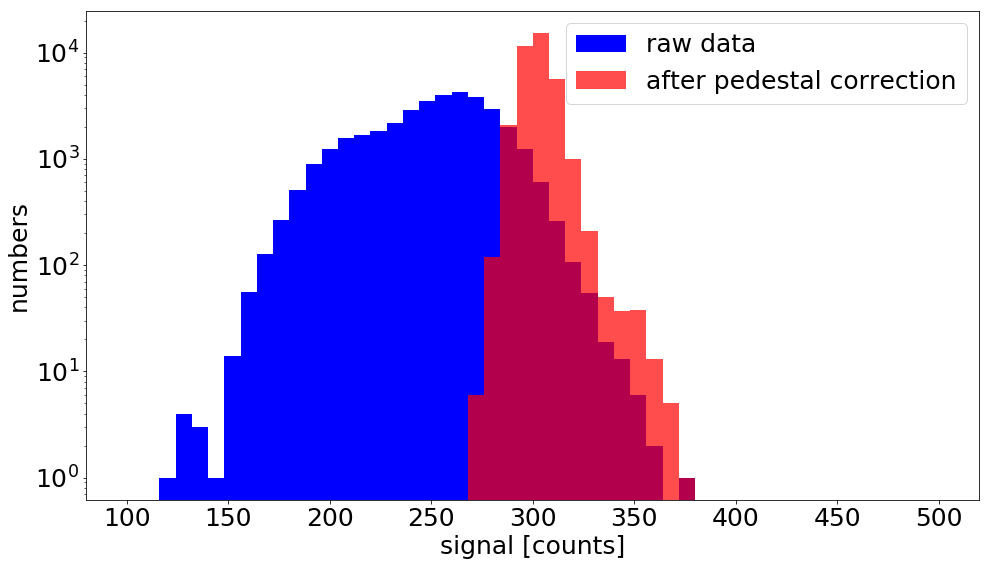

In [7]:
plt.figure(figsize=(16,9))
pixel = 10
plt.hist(waveform_raw[:, 0, pixel, :].ravel(), bins=50, color="blue", label="raw data", range=(100, 500))
plt.hist(waveform_pedestal[:, 0, pixel, :].ravel(), bins=50, color="red", label="after pedestal correction",
         range=(100, 500), alpha=0.7)
plt.legend(loc=1, fontsize=25)
plt.ylabel("numbers")
plt.xlabel("signal [counts]")
plt.yscale('log')
plt.savefig("hist_pedestal.png")
plt.show()

# Histogram after time lapse correction

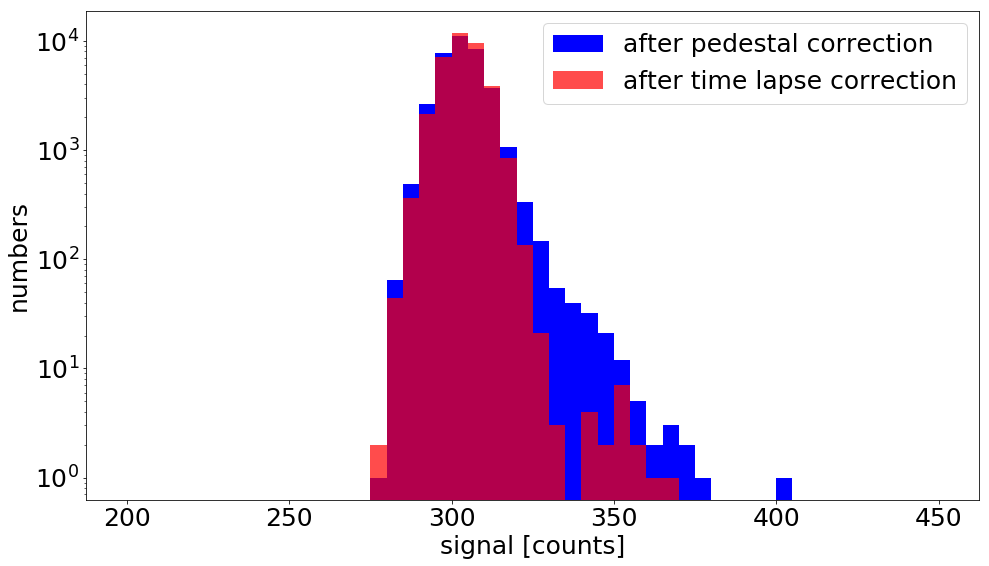

In [8]:
plt.figure(figsize=(16,9))
pixel = 50
plt.hist(waveform_pedestal[:, 0, pixel, :].ravel(), bins=50, color="blue", 
         label="after pedestal correction", range=(200, 450))
plt.hist(waveform_time_lapse_corr[:, 0, pixel, :].ravel(), bins=50, color="red", 
         label="after time lapse correction", range=(200, 450), alpha=0.7)
plt.legend(loc=1, fontsize=25)
plt.ylabel("numbers")
plt.xlabel("signal [counts]")
plt.yscale('log')
plt.savefig("hist_time_lapse_corr.png")
plt.show()

# Histogram after interpolate spike A & B

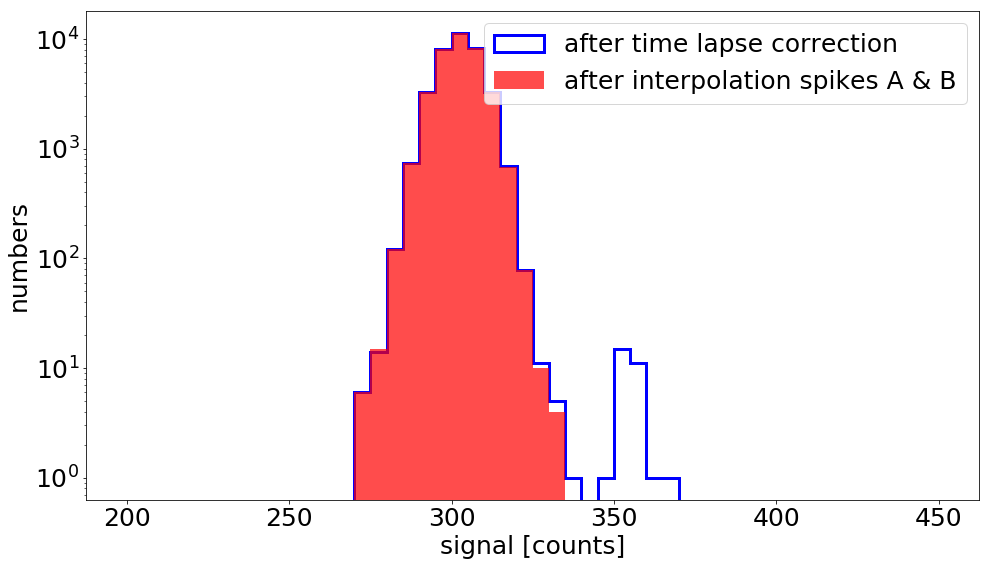

In [9]:
plt.figure(figsize=(16,9))
pixel = 10
plt.hist(waveform_time_lapse_corr[:, 0, pixel, :].ravel(), bins=50, color="blue",
         label="after time lapse correction", range=(200, 450), histtype="step", lw=3)
plt.hist(waveform_spike[:, 0, pixel, :].ravel(), bins=50, color="red", 
         label="after interpolation spikes A & B", range=(200, 450), alpha=0.7)
plt.legend(loc=1, fontsize=25)
plt.ylabel("numbers")
plt.xlabel("signal [counts]")
plt.yscale('log')
plt.savefig("hist_inter_spikes.png")
plt.show()

# Standard deviration for all pixel

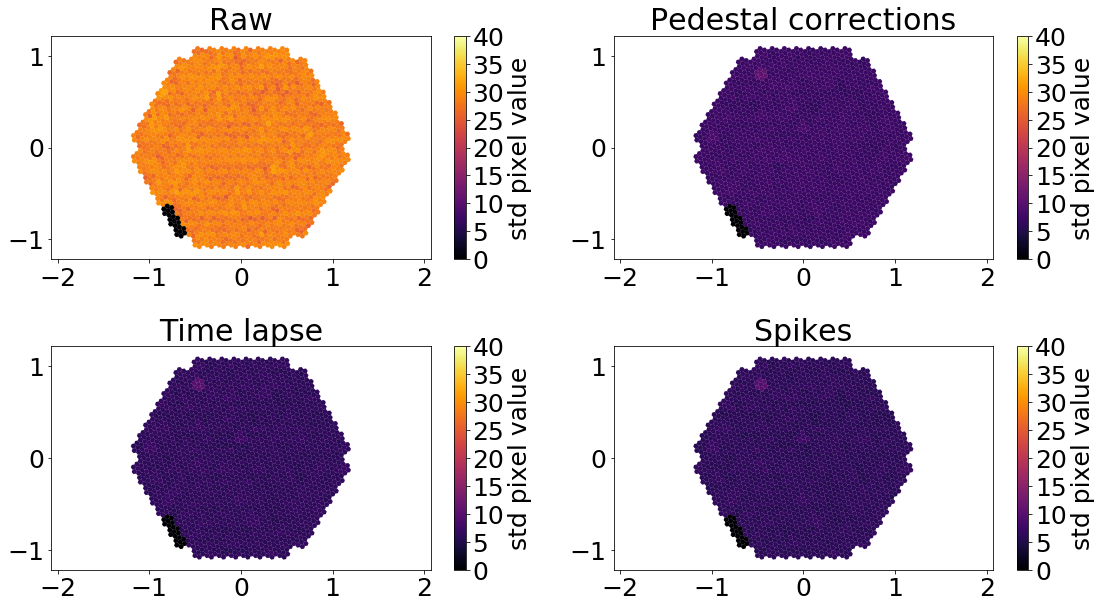

In [10]:
std_signal_raw = np.zeros(1855)
std_signal_pedestal = np.zeros(1855)
std_signal_time_lapse_corr = np.zeros(1855)
std_signal_spike = np.zeros(1855)
ev = events[100]
N_modules = 7 * ev.lst.tel[0].svc.num_modules
for pixel in range(0, N_modules):
    std_signal_raw[pixel] = np.std(waveform_raw[:, 0, pixel, 2:38].ravel())
    std_signal_pedestal[pixel] = np.std(waveform_pedestal[:, 0, pixel, 2:38].ravel())
    std_signal_time_lapse_corr[pixel] = np.std(waveform_time_lapse_corr[:, 0, pixel, 2:38].ravel())
    std_signal_spike[pixel] = np.std(waveform_spike[:, 0, pixel, 2:38].ravel())

geom = CameraGeometry.from_name("LSTCam")
fig, ax = plt.subplots(figsize=(16, 9),ncols=2, nrows=2)

disp0 = CameraDisplay(geom, ax=ax[0, 0])
disp0.cmap = 'inferno'
disp0.image = std_signal_raw
disp0.add_colorbar(ax=ax[0, 0], label='std pixel value')
disp0.set_limits_minmax(0, 40)
ax[0, 0].set_title("Raw")
ax[0, 0].set_xlabel("")
ax[0, 0].set_ylabel("")

disp0 = CameraDisplay(geom, ax=ax[0, 1])
disp0.cmap = 'inferno'
disp0.image = std_signal_pedestal
disp0.add_colorbar(ax=ax[0, 1], label='std pixel value')
disp0.set_limits_minmax(0, 40)
ax[0, 1].set_title("Pedestal corrections")
ax[0, 1].set_xlabel("")
ax[0, 1].set_ylabel("")

disp0 = CameraDisplay(geom, ax=ax[1, 0])
disp0.cmap = 'inferno'
disp0.image = std_signal_time_lapse_corr
disp0.add_colorbar(ax=ax[1, 0], label='std pixel value')
disp0.set_limits_minmax(0, 40)
ax[1, 0].set_title("Time lapse")
ax[1, 0].set_xlabel("")
ax[1, 0].set_ylabel("")

disp0 = CameraDisplay(geom, ax=ax[1, 1])
disp0.cmap = 'inferno'
disp0.image = std_signal_spike
disp0.add_colorbar(ax=ax[1, 1], label='std pixel value')
disp0.set_limits_minmax(0, 40)
ax[1, 1].set_title("Spikes")
ax[1, 1].set_xlabel("")
ax[1, 1].set_ylabel("")

plt.tight_layout()
plt.show()

# Waveform for particular number of module and pixel

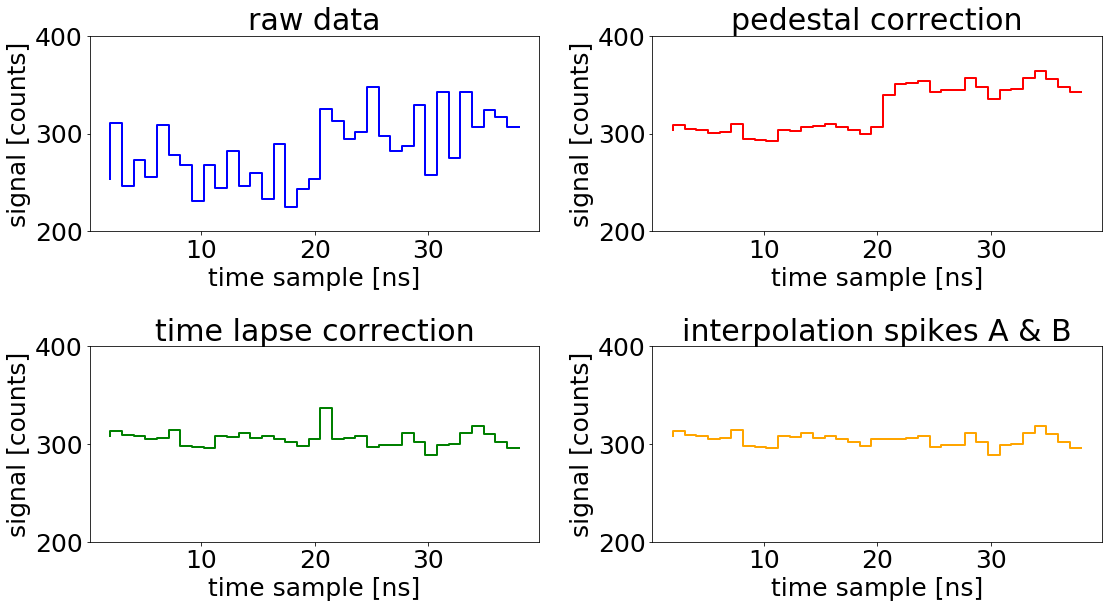

In [11]:
fig, ax = plt.subplots(figsize=(16, 9),ncols=2, nrows=2)
nr_event = 485
pixel = 188
t = np.linspace(2, 38, 36)
ax[0, 0].step(t, waveform_raw[nr_event, 0, pixel, :], color='blue', lw=2)
ax[0, 0].set_xlabel("time sample [ns]")
ax[0, 0].set_ylabel("signal [counts]")
ax[0, 0].set_ylim([200, 400])
ax[0, 0].set_title("raw data")

ax[0, 1].step(t, waveform_pedestal[nr_event, 0, pixel, :], color="red", lw=2)
ax[0, 1].set_xlabel("time sample [ns]")
ax[0, 1].set_ylabel("signal [counts]")
ax[0, 1].set_ylim([200, 400])
ax[0, 1].set_title("pedestal correction")

ax[1, 0].step(t, waveform_time_lapse_corr[nr_event, 0, pixel, :], color='green', lw=2)
ax[1, 0].set_xlabel("time sample [ns]")
ax[1, 0].set_ylabel("signal [counts]")
ax[1, 0].set_ylim([200, 400])
ax[1, 0].set_title("time lapse correction")

ax[1, 1].step(t, waveform_spike[nr_event, 0, pixel, :], color='orange', lw=2)
ax[1, 1].set_xlabel("time sample [ns]")
ax[1, 1].set_ylabel("signal [counts]")
ax[1, 1].set_ylim([200, 400])
ax[1, 1].set_title("interpolation spikes A & B")
plt.tight_layout()
plt.show()